In [98]:
import json
import requests
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pandas as pd
import matplotlib.pyplot as plt
import textacy
from random import sample
%matplotlib inline

# Display plots in this notebook, instead of externally. 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

# Get Full-Text Corpora Using Corpus-DB

First, get all the Jane Austen and George Eliot novels from Project Gutenberg.

In [2]:
# Create queries for corpus-DB
#baseURL = "http://localhost:8000" # For local testing
baseURL = "http://corpus-db.org" 

In [3]:
def getTextAndMeta(author): 
    metaResponse = requests.get(baseURL+"/api/author/"+author)
    textResponse = requests.get(baseURL+"/api/author/"+author+"/fulltext")
    meta = json.loads(metaResponse.text)
    texts = json.loads(textResponse.text)
    return meta, texts

In [4]:
austenMeta, austenTexts = getTextAndMeta("Austen, Jane")
eliotMeta, eliotTexts = getTextAndMeta("Eliot, George")

In [5]:
# Sanity check: how many novels did we get? 
len(austenMeta), len(austenTexts), len(eliotMeta), len(eliotTexts)

(20, 20, 19, 19)

In [6]:
# OK, that seems like a few too many. Let's pare it down a bit. 
# First, get the titles. 
[(book['id'], book['title']) for book in austenMeta]

[('105.0', 'Persuasion'),
 ('121.0', 'Northanger Abbey'),
 ('141.0', 'Mansfield Park'),
 ('158.0', 'Emma'),
 ('161.0', 'Sense and Sensibility'),
 ('946.0', 'Lady Susan'),
 ('1212.0', 'Love and Freindship [sic]'),
 ('1342.0', 'Pride and Prejudice'),
 ('21839.0', 'Sense and Sensibility'),
 ('25946.0', 'Gevoel en verstand'),
 ('31100.0',
  'The Complete Project Gutenberg Works of Jane Austen: A Linked Index of all PG Editions of Jane Austen'),
 ('33388.0', "Raison et sensibilité, ou les deux manières d'aimer (Tome 1)"),
 ('35151.0', "Raison et sensibilité, ou les deux manières d'aimer (Tome 2)"),
 ('35163.0', "Raison et sensibilité, ou les deux manières d'aimer (Tome 3)"),
 ('36777.0', 'Persuasion'),
 ('37431.0', "Pride and Prejudice, a play founded on Jane Austen's novel"),
 ('37634.0', "Raison et sensibilité, ou les deux manières d'aimer (Tome 4)"),
 ('42078.0',
  'The Letters of Jane Austen: Selected from the compilation of her great nephew, Edward, Lord Bradbourne'),
 ('42671.0', 'Pri

In [7]:
# Why don't we just get the ones that look like they're in English? 
# We can keep the juvenalia. 
myAustenCollection = [105, 121, 141, 158, 161, 946, 1212, 1342]

In [8]:
austenMetaSubset = [book for book in austenMeta if int(float(book['id'])) in myAustenCollection]
austenTextSubset = [book for book in austenTexts if int(book['id']) in myAustenCollection]

In [9]:
# Sanity check: how many do we have of each, now? 
len(austenMetaSubset), len(austenTextSubset)

(8, 8)

In [10]:
# Let's do the same for George Eliot. 
[(book['id'], book['title']) for book in eliotMeta]

[('145.0', 'Middlemarch'),
 ('507.0', 'Adam Bede'),
 ('550.0', 'Silas Marner'),
 ('2165.0', 'The Lifted Veil'),
 ('2171.0', 'Brother Jacob'),
 ('6688.0', 'The Mill on the Floss'),
 ('7469.0', 'Daniel Deronda'),
 ('10762.0', 'Impressions of Theophrastus Such'),
 ('17780.0', 'Scenes of Clerical Life'),
 ('20742.0', 'O May I Join the Choir Invisible! and Other Favorite Poems'),
 ('20813.0', 'How Lisa Loved the King'),
 ('24020.0', 'Romola'),
 ('24823.0', 'Silas Marner'),
 ('28289.0', 'The Essays of "George Eliot": Complete'),
 ('30273.0', 'Tom and Maggie Tulliver'),
 ('40882.0', 'Felix Holt, the Radical'),
 ('43043.0',
  "George Eliot's Life, as Related in Her Letters and Journals. Vol. 1 (of 3)"),
 ('43044.0',
  "George Eliot's Life, as Related in Her Letters and Journals. Vol. 2 (of 3)"),
 ('43045.0',
  "George Eliot's Life, as Related in Her Letters and Journals. Vol. 3 (of 3)")]

In [11]:
# Let's just grab the first 8, to make things even. 
myEliotCollection = [145, 507, 550, 2165, 2171, 6688, 7469, 10762]
eliotMetaSubset = [book for book in eliotMeta if int(float(book['id'])) in myEliotCollection]
eliotTextSubset = [book for book in eliotTexts if int(book['id']) in myEliotCollection]

In [12]:
# Sanity check: how many do we have? 
len(eliotMetaSubset), len(eliotTextSubset)

(8, 8)

# Comparative Stylometry of Austen and Eliot Novels

In [14]:
# Instantiate the models we need. 
tfidf = TfidfVectorizer(use_idf=False, max_features=800)
lsa = TruncatedSVD()

In [15]:
eliotTextsRaw = [t['text'] for t in eliotTextSubset]
austenTextsRaw = [t['text'] for t in austenTextSubset]

In [16]:
allTexts = eliotTextsRaw + austenTextsRaw
allTitles = [t['title'] for t in eliotMetaSubset] + [t['title'] for t in austenMetaSubset]

In [17]:
docTermMatrix = tfidf.fit_transform(allTexts)

In [18]:
lsaOut = lsa.fit_transform(docTermMatrix)

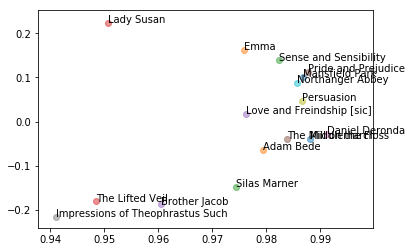

In [19]:
xs, ys = lsaOut[:,0], lsaOut[:,1]
for i in range(len(xs)): 
    plt.scatter(xs[i], ys[i], alpha=0.5)
    plt.annotate(allTitles[i], (xs[i], ys[i]))

In [20]:
# Is Love and Freindship really the most Eliot-like of Austen's novels? 